# Script mode using the API Class of SageMaker

In this notebook, we will focuse on creating a complete pipeline from the creating of a model and the deployment of it using sagemaker. Therefor, the notebook contains 4 main parts : 
- Processing
- Training
- Deployment

## Launch a Notebook instance with SageMaker

When you initiate a notebook in Amazon SageMaker, it launches an instance of the selected type in your chosen region. This instance serves as the host for the Jupyter server, where your notebook executes. To ensure data persistence, the instance is associated with an Elastic Block Store (EBS) volume. Consequently, if you stop the instance, your work remains accessible when you restart it, thanks to the linked EBS volume.

The following code illustrates the typical command you may need for your work with different import and variable declaration :

In [1]:
import boto3
import sagemaker

import pandas as pd
import numpy as np
import os

In [2]:
#Manage interactions with the Amazon SageMaker APIs and any other AWS services needed
session = sagemaker.Session()
#see the region in which we work
region = session.boto_region_name
print("AWS Region : {}".format(region))
#Get the role
role = sagemaker.get_execution_role()
#Get the default bucket URI in which you want to work
bucket = session.default_bucket()

AWS Region : us-east-1


One you have ran the different command to initialize your notebook instance, you have to upload your data to S3 if it is not already in a bucket :

In [3]:
#Upload the dataset to S3
prefix = "data_script_mode"
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'data/dataset.csv')).upload_file('predictive_maintenance.csv')

## Processing

For the processing part, the architecture is simple : 

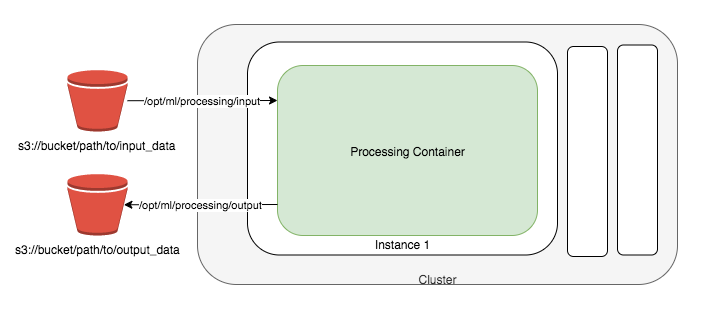

To sum-up, you launch a processing job which takes as input some data on S3, process it, and return the new data on a new S3 location that you specify. 

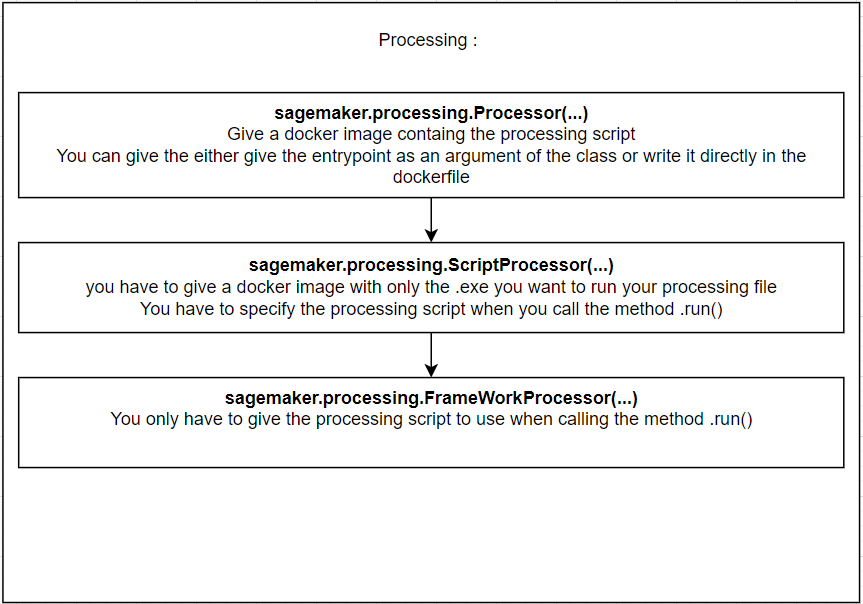


First we create a Dockerfile which will be used to run our processing job :

In [4]:
mkdir docker

mkdir: cannot create directory ‘docker’: File exists


In [5]:
%%writefile docker/dockerfile

FROM python:3.7-slim-buster

RUN pip3 install pandas scikit-learn
ENV PYTHONUNBUFFERED=TRUE


COPY processing.py .

Overwriting docker/dockerfile


In [6]:
account_id = boto3.client('sts').get_caller_identity().get('Account')
ecr_repository = 'sagemaker-processing-container'
tag = ':latest'
processing_repository_uri = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(account_id, region, ecr_repository + tag)

!docker build -t $ecr_repository docker

!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com

!aws ecr create-repository --repository-name $ecr_repository

!docker tag {ecr_repository + tag} $processing_repository_uri

!docker push $processing_repository_uri

Sending build context to Docker daemon  4.096kB
Step 1/4 : FROM python:3.7-slim-buster
3.7-slim-buster: Pulling from library/python

b88d5577: Pulling fs layer 
16e23423: Pulling fs layer 
c2981082: Pulling fs layer 
68d15a5c: Pulling fs layer 
Digest: sha256:9bd2bfc822a533f99cbe6b1311d5bf0ff136f776ebac9b985407829f17278935[5A
Status: Downloaded newer image for python:3.7-slim-buster
 ---> 099f4583c701
Step 2/4 : RUN pip3 install pandas scikit-learn
 ---> Running in fd8faf5f96c2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
from sagemaker.processing import Processor
from sagemaker.processing import ProcessingInput, ProcessingOutput
processor = Processor(
    role = role,
    image_uri = "222978838857.dkr.ecr.us-east-1.amazonaws.com/sagemaker-processing-container",
    instance_count = 1,
    instance_type = "local",
    entrypoint = ["python3", "processing.py"]
    )

bucket_path = 's3://{}'.format(bucket)

processor.run(
    inputs=[ProcessingInput(source=f"{bucket_path}/{prefix}/data/dataset.csv", destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train_data", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/test"),
    ],
    arguments=["--train-test-split-ratio", "0.2"],
)

INFO:sagemaker:Creating processing-job with name sagemaker-processing-container-2023-06-19-14-22-49-966
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-wvz2o:
    container_name: c6db4pn5zg-algo-1-wvz2o
    entrypoint:
    - python3
    - processing.py
    - --train-test-split-ratio
    - '0.2'
    environment: []
    image: 222978838857.dkr.ecr.us-east-1.amazonaws.com/sagemaker-processing-container
    networks:
      sagemaker-local:
        aliases:
        - algo-1-wvz2o
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpyl48ttct/algo-1-wvz2o/output:/opt/ml/output
    - /tmp/tmpyl48ttct/algo-1-wvz2o/config:/opt/ml/config
    - /

Creating c6db4pn5zg-algo-1-wvz2o ... 
Creating c6db4pn5zg-algo-1-wvz2o ... done
Attaching to c6db4pn5zg-algo-1-wvz2o
c6db4pn5zg-algo-1-wvz2o | Received arguments Namespace(train_test_split_ratio=0.2)
c6db4pn5zg-algo-1-wvz2o | Reading input data from /opt/ml/processing/input/dataset.csv
c6db4pn5zg-algo-1-wvz2o | Splitting data into train and test sets with ratio 0.2
c6db4pn5zg-algo-1-wvz2o |       Type  ...  Target
c6db4pn5zg-algo-1-wvz2o | UDI         ...        
c6db4pn5zg-algo-1-wvz2o | 7390     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 9276     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 2996     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 5317     1  ...       0
c6db4pn5zg-algo-1-wvz2o | 357      1  ...       0
c6db4pn5zg-algo-1-wvz2o | ...    ...  ...     ...
c6db4pn5zg-algo-1-wvz2o | 9226     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 4860     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 3265     2  ...       0
c6db4pn5zg-algo-1-wvz2o | 9846     0  ...       0
c6db4pn5zg-algo-1-wvz2o | 2733  

In [8]:
preprocessing_job_description = processor.jobs[-1].describe()

output_config = preprocessing_job_description["ProcessingOutputConfig"]

for output in output_config["Outputs"]:
    if output["OutputName"] == "train_data":
        preprocessed_training_data = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "test_data":
        preprocessed_test_data = output["S3Output"]["S3Uri"]
        
#Observe the processed data 
training_features = pd.read_csv(preprocessed_training_data + "/dataset_train.csv", index_col = "UDI",nrows=10)
print("Training features shape: {}".format(training_features.shape))
training_features.drop(["Target"], axis=1)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Training features shape: (10, 7)


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
UDI,,,,,,
7390,0,299.8,310.6,1707,32.5,124
9276,0,298.2,308.7,1605,29.4,47
2996,0,300.5,309.8,1550,37.4,148
5317,1,303.6,312.8,1689,33.1,16
357,1,297.6,308.4,1398,48.9,63
50,1,298.9,309.2,1412,44.1,140
7932,0,300.7,311.7,1499,38.4,205
1524,0,298.3,309.0,1519,36.9,41
7553,0,300.3,311.3,1525,40.7,105


## Training

In [19]:
from sagemaker import image_uris
training_image = image_uris.retrieve(framework='sklearn',region='us-east-1',version='0.20.0',image_scope='training')


from sagemaker.estimator import Estimator

metric = {
    'Name' : 'Accuracy', 'Regex' : 'Accuracy : ([0-9\\.]+)'
}

estimator = Estimator(
    role = role,
    instance_count = 1,
    instance_type = "local",
    base_job_name = "jobname",
    image_uri = training_image,
    entry_point = "train.py",
    metric_definitions = [metric]
)

estimator.fit({"train" : preprocessed_training_data, "test" : preprocessed_test_data})

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Using provided s3_resource


INFO:sagemaker:Creating training-job with name: testmetric3-2023-06-19-15-24-01-098


2023-06-19 15:24:02 Starting - Starting the training job...
2023-06-19 15:24:27 Starting - Preparing the instances for training.........
2023-06-19 15:25:51 Downloading - Downloading input data...
2023-06-19 15:26:21 Training - Downloading the training image...
2023-06-19 15:26:51 Training - Training image download completed. Training in progress...2023-06-19 15:27:07,810 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-06-19 15:27:07,814 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-19 15:27:07,825 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-06-19 15:27:08,092 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-19 15:27:08,107 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-19 15:27:08,122 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-19


2023-06-19 15:27:28 Uploading - Uploading generated training model
2023-06-19 15:27:28 Completed - Training job completed
Training seconds: 97
Billable seconds: 97


In [10]:
training_job_description = estimator.jobs[-1].describe()
print(training_job_description)
model_data_s3_uri = "{}".format(training_job_description["ModelArtifacts"]["S3ModelArtifacts"])
model_data_s3_uri

{'TrainingJobName': 'sagemaker-scikit-learn-2023-06-19-14-23-07-164', 'TrainingJobArn': 'local:arn-does-not-matter', 'ResourceConfig': {'InstanceCount': 1}, 'TrainingJobStatus': 'Completed', 'TrainingStartTime': datetime.datetime(2023, 6, 19, 14, 23, 7, 631875), 'TrainingEndTime': datetime.datetime(2023, 6, 19, 14, 24, 18, 122838), 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-222978838857/sagemaker-scikit-learn-2023-06-19-14-23-07-164/model.tar.gz'}}


's3://sagemaker-us-east-1-222978838857/sagemaker-scikit-learn-2023-06-19-14-23-07-164/model.tar.gz'

## Deploy

In [ ]:
from sagemaker.model_monitor import DataCaptureConfig



In [ ]:
from sagemaker.model import Model

inference_image = image_uris.retrieve(framework='sklearn',region='us-east-1',version='0.20.0',image_scope='training')

model = Model(
    image_uri = inference_image,
    model_data = model_data_s3_uri,
    role = role,
    entry_point = "inference.py",
)

In [ ]:
predictor = model.deploy(    
    initial_instance_count = 1,
    instance_type = "local")

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()